In [1]:
import os
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import numpy as np

from tabulate import tabulate
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.3)

In [2]:
from shapely.geometry import MultiPolygon, Polygon
from matplotlib.collections import PatchCollection
from shapely.geometry import LineString
from descartes import PolygonPatch
BLUE = '#6699cc'
GRAY = '#999999'

In [3]:
from EpiRank import epirank
from EpiRank import additional_analysis as aa

In [4]:
os.listdir("data")

['point_pos.csv', 'sars_data.csv', 'od_flow.csv', 'taiwan_county.geojson']

+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +towgs84=-752,-358,-179,-0.0000011698,0.0000018398,0.0000009822,0.00002329 +units=m +no_defs


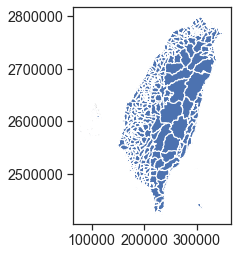

In [25]:
gfp1 = os.path.join("data", "taiwan_township.geojson")
gdf1 = gpd.read_file(gfp1)
twd67 = "+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +towgs84=-752,-358,-179,-0.0000011698,0.0000018398,0.0000009822,0.00002329 +units=m +no_defs"
gdf1.crs = twd67#        '+init=epsg:3826'
print(gdf1.crs)
#gdf1 = gdf1.to_crs(twd67)#'+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +units=m +no_defs')
#print(gdf1.crs)
gdf1.plot()

+init=epsg:3826


/home/benny/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/pyproj/crs.py:422: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  projstring = _prepare_from_string(projparams)


+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +towgs84=-752,-358,-179,-0.0000011698,0.0000018398,0.0000009822,0.00002329 +units=m +no_defs


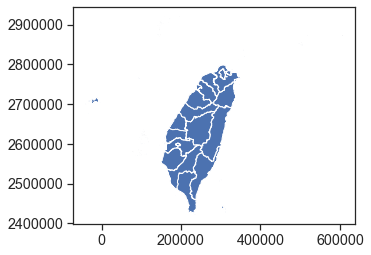

In [5]:
gfp2 = os.path.join("data", "taiwan_county.geojson")
gdf2 = gpd.read_file(gfp2)
gdf2.crs = '+init=epsg:3826'
print(gdf2.crs)
twd67 = "+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +towgs84=-752,-358,-179,-0.0000011698,0.0000018398,0.0000009822,0.00002329 +units=m +no_defs"
gdf2 = gdf2.to_crs(twd67)#'+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +units=m +no_defs')
print(gdf2.crs)
gdf2.plot()

In [6]:
fp1 = os.path.join("data", "od_flow.csv")
fp2 = os.path.join("data", "point_pos.csv")
df1 = pd.read_csv(fp1, index_col=0)
df2 = pd.read_csv(fp2, index_col=0)

In [7]:
df1.head()

,origin,destination,flow
ind,,,
0,彰化縣大村鄉,南投縣中寮鄉,2.0
1,台南縣左鎮鄉,高雄縣旗山鎮,3.0
2,高雄市小港區,屏東縣萬巒鄉,5.0
3,嘉義縣布袋鎮,嘉義縣布袋鎮,24824.0
4,台中縣大里市,台中縣烏日鄉,1455.0


In [8]:
df2.head()

,fullname,posx,posy
0,台北縣板橋市,295194.484,2766984.125
1,台北縣三重市,298098.813,2773458.625
2,台北縣中和市,299356.344,2764805.625
3,台北縣永和市,301074.047,2766766.875
4,台北縣新莊市,292525.578,2769602.250


In [9]:
target_counties = ["台北縣", "台北市", "基隆市"]

pos = {}
for i in range(len(df2)):
    row = df2.iloc[i]
    if row["fullname"][:3] in target_counties:
        pos.update({ row["fullname"]: (row["posx"], row["posy"]) })
len(pos)

48

In [10]:
target_counties = ["台北縣", "台北市", "基隆市"]
recs = []
for i in range(len(df1)):
    row = df1.iloc[i]
    if row['origin'][:3] in target_counties and row['destination'][:3] in target_counties:
        recs.append({"origin": row['origin'], "destination": row['destination'], "flow": row['flow']})
len(recs)

1806

In [11]:
df3 = pd.DataFrame.from_dict(recs)
df3 = df3[["origin", "destination", "flow"]]
df3.head()

,origin,destination,flow
0,台北縣中和市,台北縣八里鄉,79.0
1,台北縣樹林市,台北縣板橋市,4371.0
2,基隆市信義區,台北縣三芝鄉,3.0
3,台北縣瑞芳鎮,基隆市中山區,250.0
4,台北縣萬里鄉,台北縣淡水鎮,71.0


In [12]:
g = epirank.make_DiGraph(df3, origin_col='origin', destination_col='destination', flow_col='flow', 
                         largest_connected_component=False, exclude_selfloop=False)

graph construction done, no. nodes: 48, no. edges: 1806


In [13]:
epi_vals05 = epirank.run_epirank(g, daytime=0.5, d=0.95)

start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 366


In [14]:
gb1,bb = aa.htbreak(epi_vals05)
gb2 = [ v for k,v in gb1.items() ]
print(gb2.count(0), gb2.count(1), gb2.count(2), gb2.count(3))

28 11 4 5


In [15]:
len(gb1)

48

In [16]:
gb3 = defaultdict(list)
for k,v in gb1.items():
    #print(k,v)
    gb3[v].append(k)
len(gb3)

4

In [17]:
def plot_boundaries(gdf, ax, fc=BLUE, ec=BLUE, alpha=0.3, zorder=1):
    polys = []
    for g in gdf.geometry:
        if type(g)==MultiPolygon:
            for gg in g:
                poly = PolygonPatch(gg, fc=fc, ec=ec, alpha=alpha, zorder=zorder )
                polys.append(poly)
        else:
            poly = PolygonPatch(g, fc=fc, ec=ec, alpha=alpha, zorder=zorder )
        polys.append(poly)
    pc = PatchCollection(polys, match_original=True)
    ax.add_collection(pc)

In [18]:
def plot_res(gb_res, ax):
    for k,vlist in gb_res.items():
        colors = ['xkcd:crimson', 'xkcd:pinkish orange', 'xkcd:sandy', 'xkcd:green']
        xs = []
        ys = []
        s = (k+1)*60
        c = colors[3-k]
        for v in vlist:
            p = pos[v]
            xs.append(p[0])
            ys.append(p[1])
        ax.scatter(xs, ys, fc=c, s=s, zorder=5)

[]

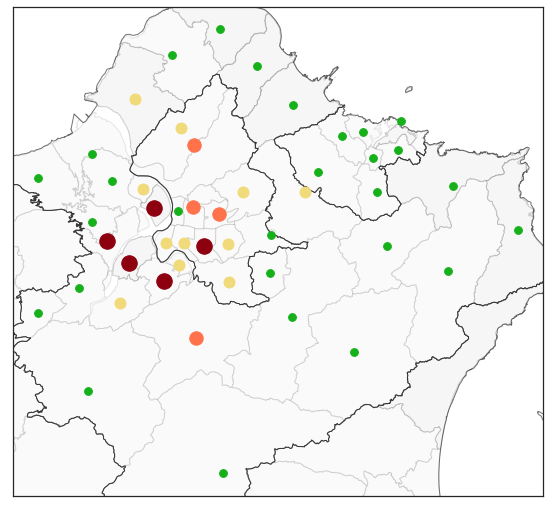

In [26]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_aspect("equal")
plot_res(gb3, ax)
plot_boundaries(gdf1, ax, fc="lightgrey", ec='k', alpha=.1)
plot_boundaries(gdf2, ax, fc='none', ec='k', alpha=0.6, zorder=2)
ax.set_xticks([])
ax.set_yticks([])

In [28]:
gdf1.crs

'+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +towgs84=-752,-358,-179,-0.0000011698,0.0000018398,0.0000009822,0.00002329 +units=m +no_defs'

In [29]:
gdf2.crs

'+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=aust_SA +towgs84=-752,-358,-179,-0.0000011698,0.0000018398,0.0000009822,0.00002329 +units=m +no_defs'

In [30]:
fp4 = os.path.join("data", "sars_data.csv")
df4 = pd.read_csv(fp4)
df4.head()

,fullname,sars
0,基隆市七堵區,0
1,基隆市中山區,0
2,基隆市中正區,0
3,基隆市仁愛區,0
4,基隆市安樂區,1


In [31]:
sum(df4["sars"])/347

0.8126801152737753

In [32]:
sars = {}
for n,c in zip(df4['fullname'].tolist(), df4['sars'].tolist()):
    sars[n] = c
gs, bbs = aa.htbreak(sars)

In [33]:
gs3 = defaultdict(list)
for k,v in gs.items():
    gs3[v].append(k)
len(gs3)

4

[]

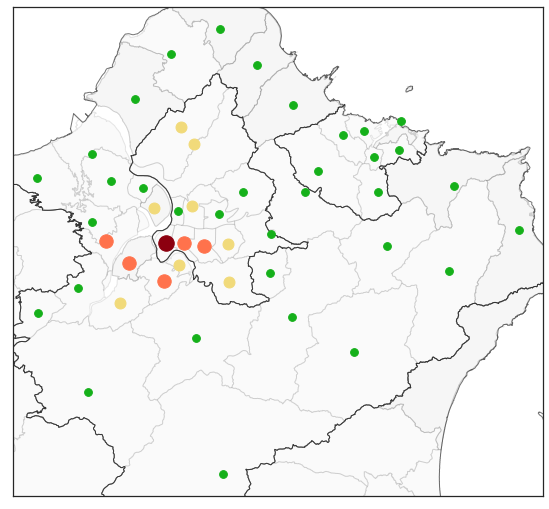

In [34]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_aspect("equal")
plot_res(gs3, ax)
plot_boundaries(gdf1, ax, fc="lightgrey", ec='k', alpha=.1)
plot_boundaries(gdf2, ax, fc='none', ec='k', alpha=0.6, zorder=2)
ax.set_xticks([])
ax.set_yticks([])

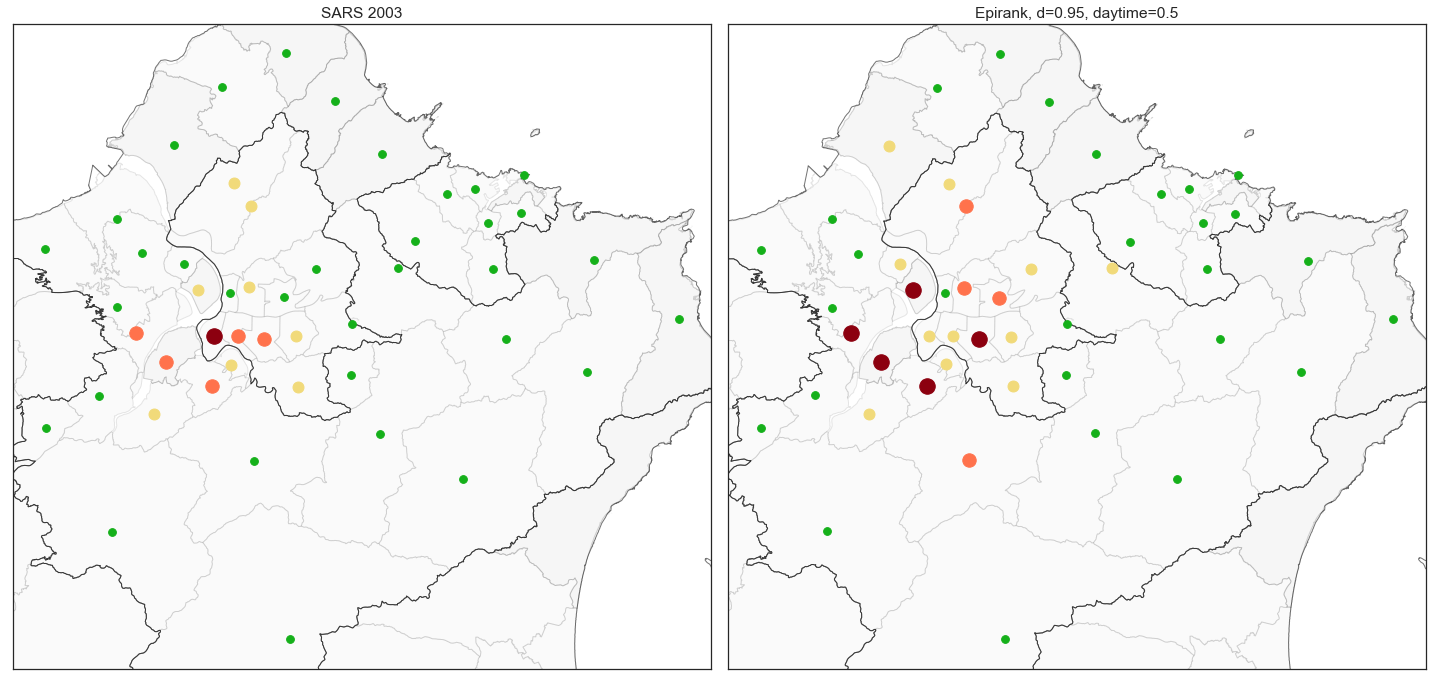

In [35]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

plot_res(gs3, axs[0])
axs[0].set_title("SARS 2003")
plot_res(gb3, axs[1])
axs[1].set_title("Epirank, d=0.95, daytime=0.5")

for ax in axs:
    ax.set_aspect("equal")
    plot_boundaries(gdf1, ax, fc="lightgrey", ec='k', alpha=.1)
    plot_boundaries(gdf2, ax, fc='none', ec='k', alpha=0.6, zorder=2)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
#plt.savefig("Analysis_SARS_fig.png", bbox_inches="tight", dpi=100)

In [36]:
cores = {0:'NC', 1:'III', 2:'II', 3:'I'}

gb7 = { k:'ER '+cores[v] for k,v in gb1.items() }

In [37]:

gs7 = { k:'SARS '+cores[v] for k,v in gs.items() }


In [38]:

df_mat_s = pd.DataFrame.from_dict({'ER': gb7, 'SARS':gs7})
table1 = df_mat_s.pivot_table(index='ER', columns='SARS', aggfunc=len, fill_value=0)

In [39]:
print(tabulate(table1, headers=table1.columns, tablefmt='pipe'))

|        |   SARS I |   SARS II |   SARS III |   SARS NC |
|:-------|---------:|----------:|-----------:|----------:|
| ER I   |        0 |         4 |          1 |         0 |
| ER II  |        0 |         0 |          2 |         2 |
| ER III |        1 |         1 |          5 |         4 |
| ER NC  |        0 |         0 |          0 |        28 |


In [40]:
epi_vals05

{'台北縣中和市': 0.044184614094690974,
 '台北縣八里鄉': 0.0075112146690948295,
 '台北縣樹林市': 0.019805509666611865,
 '台北縣板橋市': 0.05522913912313852,
 '基隆市信義區': 0.013141191415174077,
 '台北縣三芝鄉': 0.008383653086380768,
 '台北縣瑞芳鎮': 0.014461906752246775,
 '基隆市中山區': 0.013122193663577189,
 '台北縣萬里鄉': 0.008841351146808266,
 '台北縣淡水鎮': 0.021714858472170754,
 '台北縣土城市': 0.027659642428387244,
 '台北市萬華區': 0.023995166585296338,
 '台北市文山區': 0.032659684855378034,
 '台北縣石碇鄉': 0.004609613462171318,
 '台北縣汐止市': 0.02659884938801278,
 '台北縣蘆洲市': 0.021214966878687753,
 '台北市信義區': 0.03151072270887215,
 '台北市中山區': 0.03793195935425477,
 '基隆市暖暖區': 0.010237372906998662,
 '台北縣深坑鄉': 0.006695348892321319,
 '台北縣石門鄉': 0.006109628290011124,
 '台北縣三重市': 0.044227795803902695,
 '基隆市安樂區': 0.017648174447952036,
 '台北市內湖區': 0.032167918641006016,
 '台北市松山區': 0.035887801746813996,
 '台北縣新店市': 0.03530271661518302,
 '台北縣平溪鄉': 0.006844865753197257,
 '台北市中正區': 0.028245602637917432,
 '台北市大安區': 0.045389967175417545,
 '台北市北投區': 0.030233827000489717,
 '台北市士林區': 0.0

In [41]:
sars

{'基隆市七堵區': 0,
 '基隆市中山區': 0,
 '基隆市中正區': 0,
 '基隆市仁愛區': 0,
 '基隆市安樂區': 1,
 '基隆市信義區': 0,
 '基隆市暖暖區': 1,
 '台北市士林區': 7,
 '台北市大同區': 4,
 '台北市大安區': 26,
 '台北市中山區': 8,
 '台北市中正區': 24,
 '台北市內湖區': 4,
 '台北市文山區': 10,
 '台北市北投區': 9,
 '台北市松山區': 5,
 '台北市信義區': 12,
 '台北市南港區': 3,
 '台北市萬華區': 44,
 '台北縣八里鄉': 0,
 '台北縣三芝鄉': 0,
 '台北縣三重市': 16,
 '台北縣三峽鎮': 1,
 '台北縣土城市': 9,
 '台北縣中和市': 24,
 '台北縣五股鄉': 5,
 '台北縣平溪鄉': 0,
 '台北縣永和市': 7,
 '台北縣石門鄉': 1,
 '台北縣石碇鄉': 0,
 '台北縣汐止市': 2,
 '台北縣坪林鄉': 0,
 '台北縣林口鄉': 0,
 '台北縣板橋市': 22,
 '台北縣金山鄉': 0,
 '台北縣泰山鄉': 1,
 '台北縣烏來鄉': 0,
 '台北縣貢寮鄉': 0,
 '台北縣淡水鎮': 0,
 '台北縣深坑鄉': 0,
 '台北縣新店市': 5,
 '台北縣新莊市': 21,
 '台北縣瑞芳鎮': 1,
 '台北縣萬里鄉': 0,
 '台北縣樹林市': 4,
 '台北縣雙溪鄉': 0,
 '台北縣蘆洲市': 5,
 '台北縣鶯歌鎮': 0}

In [42]:
aa.get_pearson_cor(epi_vals05, sars)

(0.6866, '***')

In [43]:
aa.get_spearman_cor(epi_vals05, sars)

(0.8361, '***')

In [44]:
res_p = {}
res_s = {}
for i in range(21):
    dt = i*0.05
    #print(dt)
    for j in range(1,21):
        d = j*0.05
        #print(d)
        epiv = epirank.run_epirank(g, daytime=dt, d=d)
        pcor = aa.get_pearson_cor(epiv, sars)
        scor = aa.get_spearman_cor(epiv, sars)
        res_p[(dt,d)] = pcor
        res_s[(dt,d)] = scor
        print(dt, d)
    #break

start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 12
0.0 0.05
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 15
0.0 0.1
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 18
0.0 0.15000000000000002
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 21
0.0 0.2
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 25
0.0 0.25
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 28
0.0 0.30000000000000004
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 31
0.0 0.35000000000000003
start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 35
0.0 0.4
start preparing matrices
preparation done, start itera

In [45]:
res_p2 = { k:v[0] for k,v in res_p.items() }
res_s2 = { k:v[0] for k,v in res_s.items() }

In [46]:
res_p3 = []
for k,v in res_p2.items():
    dt, d = k
    res_p3.append({"daytime":"{:.2f}".format(dt), "damping_factor":"{:.2f}".format(d), "cor":v})
res_s3 = []
for k,v in res_s2.items():
    dt, d = k
    res_s3.append({"daytime":"{:.2f}".format(dt), "damping_factor":"{:.2f}".format(d), "cor":v})

In [47]:
df_res_p = pd.DataFrame.from_records(res_p3)
res_p4 = df_res_p.pivot("daytime", "damping_factor", "cor")

df_res_s = pd.DataFrame.from_records(res_s3)
res_s4 = df_res_s.pivot("daytime", "damping_factor", "cor")

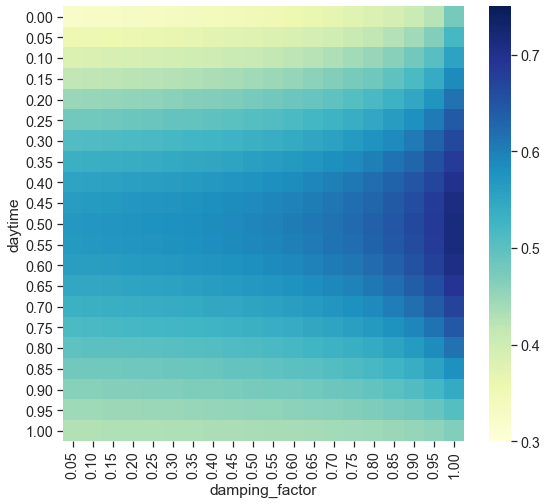

In [48]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(res_p4, cmap="YlGnBu", annot=False, linewidths=.0, ax=ax, vmin=0.3, vmax=0.75, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7]})

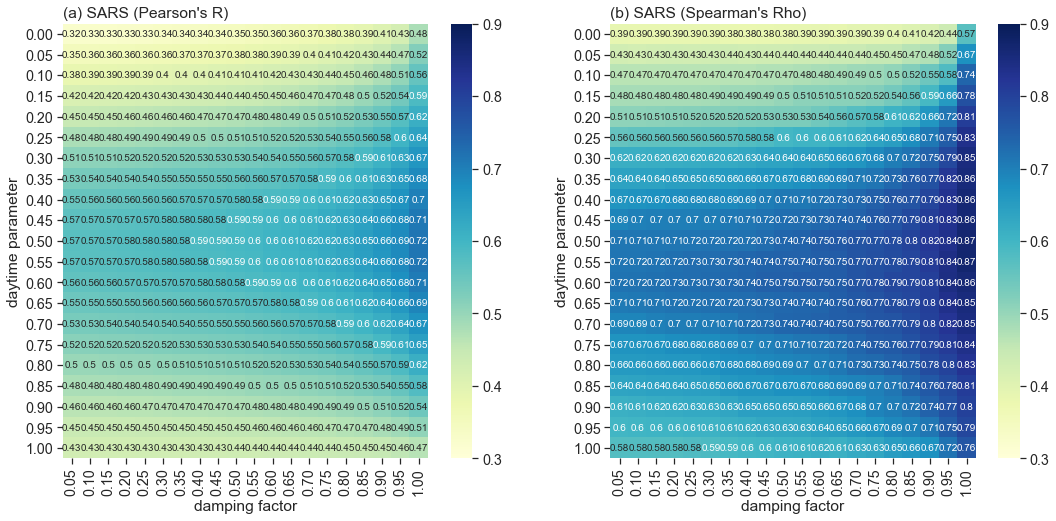

In [49]:
f, axs = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(res_p4, cmap="YlGnBu", annot=True, linewidths=.0, ax=axs[0], vmin=0.3, vmax=0.9, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})
sns.heatmap(res_s4, cmap="YlGnBu", annot=True, linewidths=.0, ax=axs[1], vmin=0.3, vmax=0.9, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

axs[0].set_title("(a) SARS (Pearson's R)", loc="left")
axs[1].set_title("(b) SARS (Spearman's Rho)", loc="left")

for ax in axs:
    ax.set_xlabel("damping factor")
    ax.set_ylabel("daytime parameter")
    
plt.savefig("Analysis_SARS_fig_sensitivity_with_annotate.png", bbox_inches="tight", dpi=100)

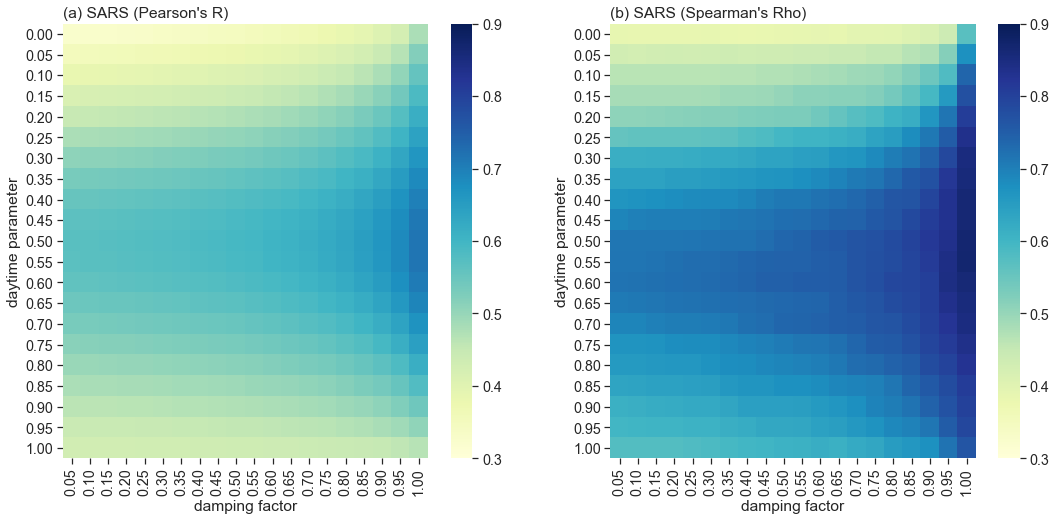

In [50]:
f, axs = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(res_p4, cmap="YlGnBu", annot=False, linewidths=.0, ax=axs[0], vmin=0.3, vmax=0.9, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})
sns.heatmap(res_s4, cmap="YlGnBu", annot=False, linewidths=.0, ax=axs[1], vmin=0.3, vmax=0.9, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

axs[0].set_title("(a) SARS (Pearson's R)", loc="left")
axs[1].set_title("(b) SARS (Spearman's Rho)", loc="left")

for ax in axs:
    ax.set_xlabel("damping factor")
    ax.set_ylabel("daytime parameter")
    
plt.savefig("Analysis_SARS_fig_sensitivity.png", bbox_inches="tight", dpi=100)

In [51]:
p5 = res_p4.to_numpy()
p6 = np.empty(p5.shape)
for i in range(p5.shape[0]):
    for j in range(p5.shape[1]):
        v = p5[i][j]
        vv = round(v, 2)
        p6[i][j] = vv
p6 = np.where(p5<0.7, "", p6)


s5 = res_s4.to_numpy()
s6 = np.empty(s5.shape)
for i in range(s5.shape[0]):
    for j in range(s5.shape[1]):
        v = s5[i][j]
        vv = round(v, 2)
        s6[i][j] = vv
s6 = np.where(s5<0.8, "", s6)

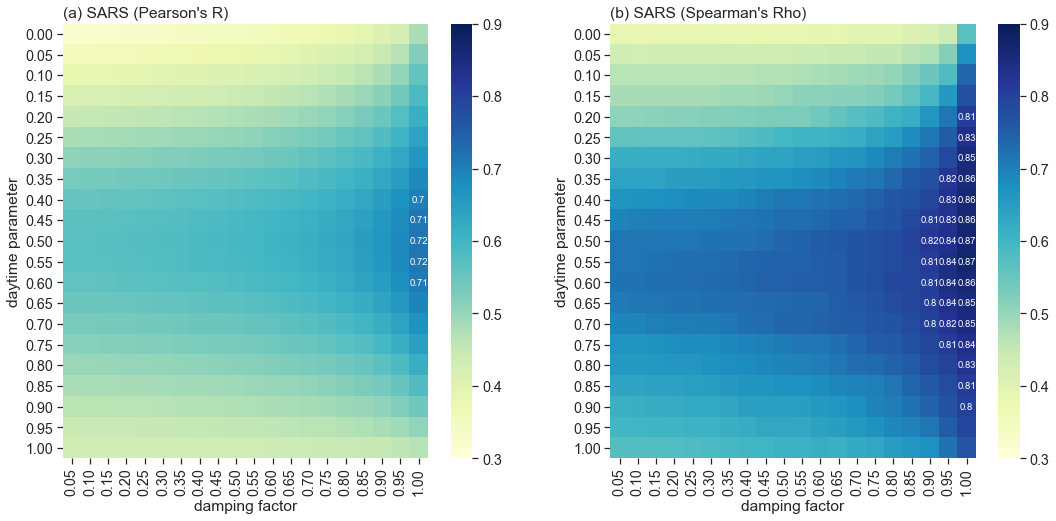

In [52]:
f, axs = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(res_p4, cmap="YlGnBu", annot=p6, fmt="s", annot_kws={"fontsize":9.5}, linewidths=.0, ax=axs[0], vmin=0.3, vmax=0.9, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})
sns.heatmap(res_s4, cmap="YlGnBu", annot=s6, fmt="s", annot_kws={"fontsize":9.5}, linewidths=.0, ax=axs[1], vmin=0.3, vmax=0.9, cbar_kws={"ticks":[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

axs[0].set_title("(a) SARS (Pearson's R)", loc="left")
axs[1].set_title("(b) SARS (Spearman's Rho)", loc="left")

for ax in axs:
    ax.set_xlabel("damping factor")
    ax.set_ylabel("daytime parameter")
    
plt.savefig("Analysis_SARS_fig_sensitivity_with_top_annotate.png", bbox_inches="tight", dpi=100)

In [53]:
epi_vals_final = epirank.run_epirank(g, daytime=0.55, d=1.)
gb1,bb = aa.htbreak(epi_vals_final)
gb2 = [ v for k,v in gb1.items() ]
print(gb2.count(0), gb2.count(1), gb2.count(2), gb2.count(3))
gb3 = defaultdict(list)
for k,v in gb1.items():
    #print(k,v)
    gb3[v].append(k)
len(gb3)

start preparing matrices
preparation done, start iterating
epirank calculation done after iteration: 793
26 13 4 5


4

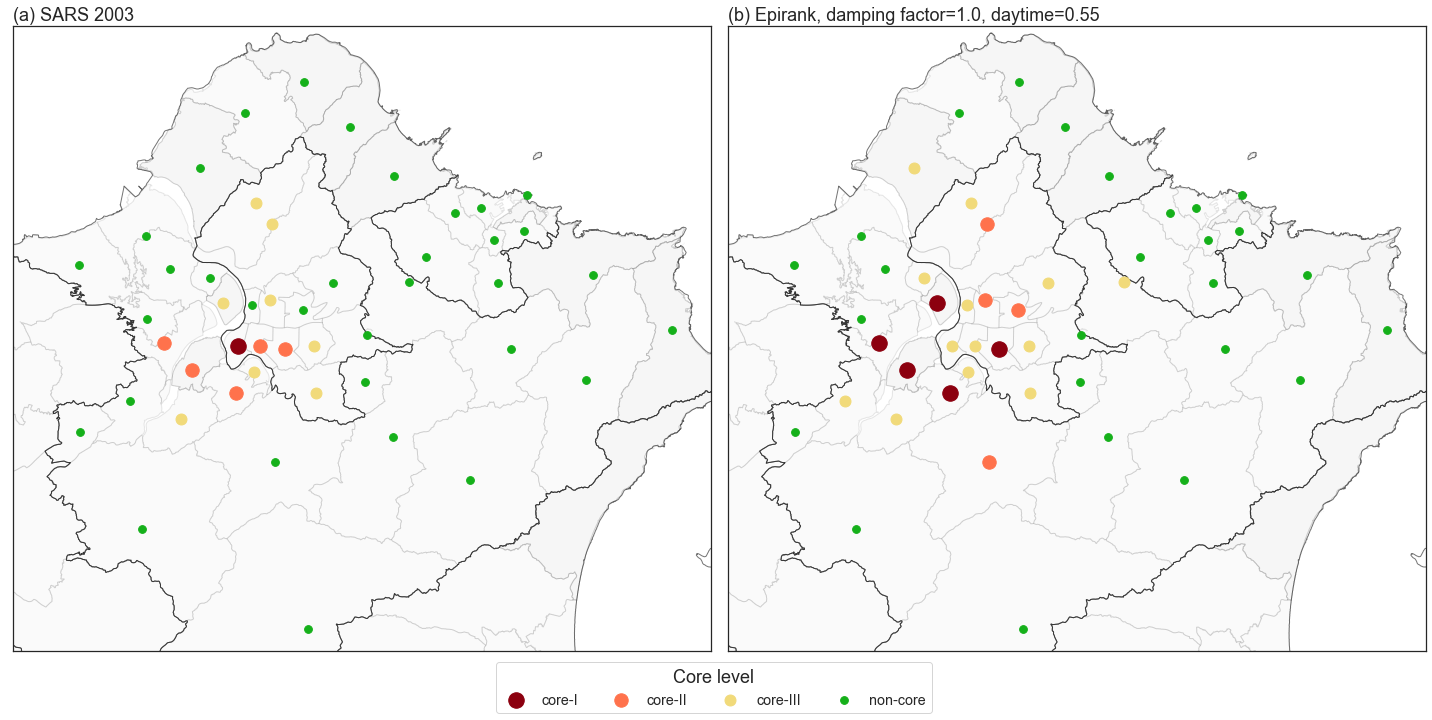

In [54]:
fig, axs = plt.subplots(1,2, figsize=(20,10))

plot_res(gs3, axs[0])
axs[0].set_title("(a) SARS 2003", loc="left", fontsize=18)
plot_res(gb3, axs[1])
axs[1].set_title("(b) Epirank, damping factor=1.0, daytime=0.55", loc="left", fontsize=18)

for ax in axs:
    ax.set_aspect("equal")
    plot_boundaries(gdf1, ax, fc="lightgrey", ec='k', alpha=.1)
    plot_boundaries(gdf2, ax, fc='none', ec='k', alpha=0.6, zorder=2)
    ax.set_xlim([278000, 345000])
    ax.set_ylim([2740000, 2800000])
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

#sizes = {0:55, 1:75, 2:114, 3:150}
sizes = { k:(k+1)*60 for k in range(4) }
colors = ['xkcd:crimson', 'xkcd:pinkish orange', 'xkcd:sandy', 'xkcd:green']
l=3
pt1 = ax.scatter([],[], s=sizes[l], c=colors[3-l])
l=2
pt2 = ax.scatter([],[], s=sizes[l], c=colors[3-l])
l=1
pt3 = ax.scatter([],[], s=sizes[l], c=colors[3-l])
l=0
pt4 = ax.scatter([],[], s=sizes[l], c=colors[3-l])
legend = axs[1].legend([pt1, pt2, pt3, pt4], ["core-I", "core-II", "core-III", "non-core"], 
                    title='Core level', fancybox=True, ncol=4, frameon=1, 
                    loc='lower center', bbox_to_anchor=(-0.02, -0.11))
legend.set_title('Core level',prop={'size':18})

plt.savefig("Analysis_SARS_fig.png", bbox_inches="tight", dpi=100)

In [55]:
df4.head()

,fullname,sars
0,基隆市七堵區,0
1,基隆市中山區,0
2,基隆市中正區,0
3,基隆市仁愛區,0
4,基隆市安樂區,1


In [56]:
sum(df4["sars"])

282

In [57]:
df4["proportion"] = df4["sars"]/282

In [58]:
df4.sort_values(by="sars", ascending=False)

,fullname,sars,proportion
18,台北市萬華區,44,0.156028
9,台北市大安區,26,0.092199
24,台北縣中和市,24,0.085106
11,台北市中正區,24,0.085106
33,台北縣板橋市,22,0.078014
41,台北縣新莊市,21,0.074468
21,台北縣三重市,16,0.056738
16,台北市信義區,12,0.042553
13,台北市文山區,10,0.035461
14,台北市北投區,9,0.031915


In [59]:
np.quantile(df4[df4["sars"]>0]["sars"], .95)

25.199999999999996

In [60]:
15.6/9.2

1.6956521739130437

In [61]:
df_res = pd.DataFrame.from_dict(epi_vals_final, orient="index").rename(columns={0:"epirank"})
df_res.sort_values(by="epirank", ascending=False)

,epirank
台北縣板橋市,0.069096
台北市大安區,0.059401
台北縣三重市,0.054392
台北縣中和市,0.052893
台北縣新莊市,0.052878
台北市中山區,0.050353
台北市士林區,0.044797
台北市松山區,0.043836
台北縣新店市,0.038912
台北市信義區,0.037261


In [62]:
df_res["epirank"].sum()

0.999999999999996